<a href="https://colab.research.google.com/github/arcrz28/Proyectos/blob/main/Clasificaci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/MyDrive/Colab Notebooks/Diplomado

/content/drive/MyDrive/Colab Notebooks/Diplomado


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D, Dropout,Activation,MaxPooling2D,Flatten
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
from tensorflow.keras.preprocessing import image
import os
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
from tensorflow.keras.utils import to_categorical

In [4]:
!pip install wandb

In [21]:
import wandb
#from wandb.keras import WandbCallback
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: arcecrz-06 (arcecrz) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [22]:

wandb.init(project="clasificación")
wandb.config.learning_rate = learning_rate
wandb.config.epochs = epochs
wandb.config.batch_size = batch_size
wandb.config.loss = loss
#wandb.config.optimizer = optimizer

In [15]:
train_dir = 'Dataset/minitrain' #directorio de entrenamiento
test_dir = 'Dataset/minitest' #directorio de prueba

### Para saber cuantas imágenes hay
cat_files_path = os.path.join(train_dir, 'cat/*')
dog_files_path = os.path.join(train_dir, 'dog/*')

cat_files = sorted(glob(cat_files_path))
dog_files = sorted(glob(dog_files_path))

n_files = len(cat_files) + len(dog_files)
print(n_files)

cat_files_path_test = os.path.join(test_dir, 'cat/*')
dog_files_path_test = os.path.join(test_dir, 'dog/*')

cat_files_test = sorted(glob(cat_files_path_test))
dog_files_test = sorted(glob(dog_files_path_test))

n_files_test = len(cat_files_test) + len(dog_files_test)
print(n_files_test)

4000
1260


Found 4000 images belonging to 2 classes.
Found 1260 images belonging to 2 classes.


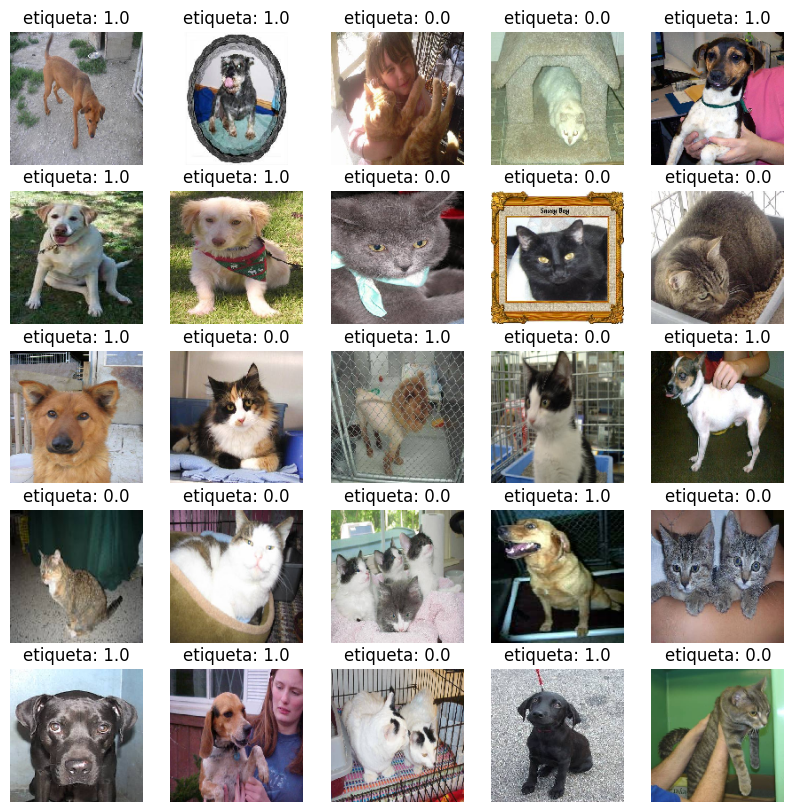

In [32]:


train_dir = 'Dataset/minitrain'
test_dir = 'Dataset/minitest'
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')


plt.figure(figsize=(10,10))

for i, (X_train_batch, y_train_batch) in enumerate(train_generator):
    if i >= 25:  # Solo manda 25 imágenes
        break
    plt.subplot(5, 5, i + 1)
    plt.imshow(X_train_batch[0], cmap='gray')
    plt.title(f"etiqueta: {y_train_batch[0]}")
    plt.axis('off')

In [34]:
#Redimensional las imágenes para incluir el canal CNN
#Las CNN esperan la información de la imagen que va a ser el alto, ancho y canales
train_dir = np.expand_dims(train_dir, -1) #Forma (60k, 28, 28, 1)
test_dir = np.expand_dims(test_dir, -1) #Forma (10k, 28, 28, 1)

In [39]:
#convertir etiquetas a one-hot
#Ejemplo
#El 3 a one hot ---- [0,0,0,1, .......,0]
#el cero a one hot quedaría [1,0, .........., 0]
train_labels = np.array([0] * len(cat_files) + [1] * len(dog_files))  # 0 para gato, 1 para perro
test_labels = np.array([0] * len(cat_files_test) + [1] * len(dog_files_test))

train_labels_onehot = to_categorical(train_labels, num_classes=2)
test_labels_onehot = to_categorical(test_labels, num_classes=2)


In [40]:
print("Nueva firma de train_dir" , train_dir.shape)

Nueva firma de train_dir (1,)


In [43]:
print("Nueva firma de train_labels " , train_labels_onehot.shape)

Nueva firma de train_labels  (4000, 2)


In [49]:
model = keras.Sequential([
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(150,150,3)),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Flatten(), #aplanar de 3D a vector
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2), #evita el overfitting, Corrected typo: Drpout to Dropout
    #apaga el 20% de las neuronas

    #Capa de salida con 10 neuroncitas, una para cada dígito
    layers.Dense(1, activation='sigmoid')
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    10,616,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,636,481 (40.57 MB)

 Trainable params: 10,636,481 (40.57 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
#compliar
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(train_generator,  batch_size=150, epochs=10, validation_data=test_generator,callbacks=[WandbMetricsLogger(log_freq=5),
                      WandbModelCheckpoint("models")) #batch es cuántas imágenes/datos

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5845 - loss: 0.6734

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 539s 4s/step - accuracy: 0.5847 - loss: 0.6733 - val_accuracy: 0.6944 - val_loss: 0.5883
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.7235 - loss: 0.5608 - val_accuracy: 0.6960 - val_loss: 0.6026
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.7922 - loss: 0.4545 - val_accuracy: 0.7437 - val_loss: 0.5300
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.8584 - loss: 0.3351 - val_accuracy: 0.7397 - val_loss: 0.5846
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - accuracy: 0.9067 - loss: 0.2435 - val_accuracy: 0.7341 - val_loss: 0.6018
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.9413 - loss: 0.1643 - val_accuracy: 0.7286 - val_loss: 0.7319
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.9725 - loss: 0.0892 - val_accuracy: 0.7349 - val_loss: 0.9386
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.9812 - loss: 0.0642 - val_accuracy: 0.725

In [56]:
test_loss, test_acc = model.evaluate(train_generator, verbose=1)
print(f"Precisión en el conjunto de prueba: {test_acc * 100:.2f}%")

125/125 ━━━━━━━━━━━━━━━━━━━━ 62s 497ms/step - accuracy: 0.9968 - loss: 0.0147
Precisión en el conjunto de prueba: 99.75%


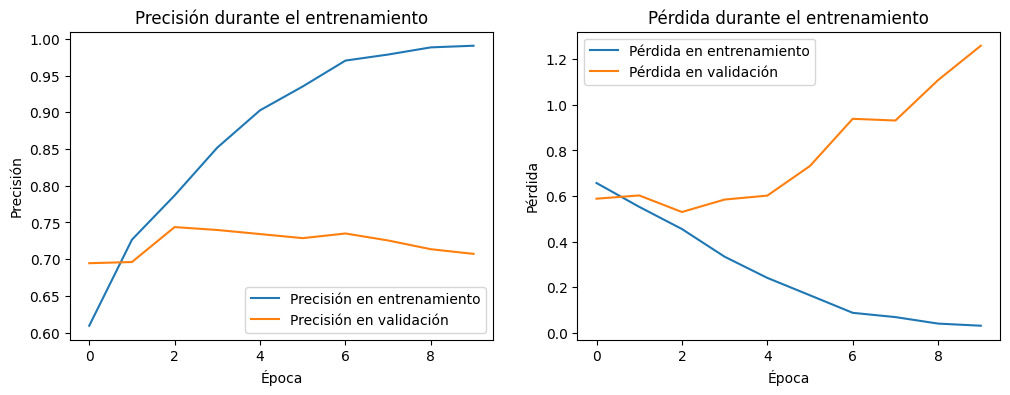

In [57]:
plt.figure(figsize=(12, 4)) ###grafica de precision durante entrenamiento
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.subplot(1, 2, 2) ##graf perdida durante entrenamiento
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [ ]:
##Funciona el código?

predictions = model.predict(train_generator)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(train_generator, axis=1)

plt.figure(figsize=(15,15))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(train_generator[i].squeeze(), cmap='gray')
    color = 'purple' if predicted_labels[i] == true_labels[i] else 'red'
    plt.title(f"Pred: {predicted_labels[i]}\nReal: {true_labels[i]}", color=color)
    plt.axis('off')
plt.show()

125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 485ms/step


Para esta parte, estaba trabajando ya hace tiempo con este proyecto pero no sé que tan bien salió o que me falta cambiar y es de clasificación de perros y gatos.